# IRから株価の予測 (パーセプトロン)


パーセプトロンを使い適時開示情報のタイトルから、その銘柄の株価が発表直後に上がるか下がるかを予測する。

## データ

データは事前にmongodbに保存されており、事前に`ir_csv_dump.py`にてデータを取得し、csvにて出力しておいてある。


* k-db.com (株価データ): http://k-db.com/
* 適時開示情報: https://www.release.tdnet.info/inbs/I_main_00.html

※ 今回はk-db.comの前場後場のデータを使用しており、そのため使用する開示情報は朝か昼か大引け後のもののみとなっている

### 開示情報のベクトル化

開示情報はタイトルのみ使用する。タイトルはtf-idfによってベクトル化される(今回はtf-idfのアルゴリズムはライブラリを用いた)。これらの作業はすべて`ir_csv_dump.py`にて行った。

### ラベルについて

株価が発表直後プラスになった場合は1, マイナスになったら-1とした


必要なモジュールをインポート

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame

/opt/conda/envs/python2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
LENGTH = 1936  # ベクトルの横幅

In [3]:
def import_data(filename_images, filename_labels):
    train_set = pd.read_csv(filename_images, header=None)
    labels_data = pd.read_csv(filename_labels, header=None)
    train_set['type'] = labels_data[0]
    return train_set

In [4]:
train_set = import_data("ir_vectors.txt", "ir_vectors_labels.txt")
train_set.shape

(1000, 1937)

訓練データからバイアスを求める関数

In [5]:
def calc_bias(train_set):
    return (1.0 / LENGTH) * sum([train_set[i].mean() for i in range(LENGTH)])

以下を計算する関数

```
w0 * bias + w1 * x0 + w2 * x1 + ... + wn * xn-1
```

In [6]:
def calc_partial_E(w0, W, bias, char):
    # w0
    total = w0 * bias
    # w1 ~ wn
    total += (char[0:LENGTH] * W).sum()
    r = char['type'] * total
    return r

# test
w0 = 3
W = [1] * LENGTH
bias = calc_bias(train_set)
for i, char in train_set[3:6].iterrows():
    print(calc_partial_E(w0, W, bias, char))

2.26096701362
-3.10623136747
-2.1936697989


学習用関数

In [7]:
def run_train(train_set):
    w0 = 0
    W = [0] * LENGTH
    bias = calc_bias(train_set)
    paramhist = DataFrame([W])
    for i in range(100):
        for j, char in train_set.iterrows():
            r = calc_partial_E(w0, W, bias, char)
            if r <= 0:
                # update w0 and W
                w0 += char['type'] * 1
                for k in range(len(W)):
                    W[k] += char['type'] * char[k]
        paramhist = paramhist.append(Series([w0] + W), ignore_index=True)
    
    # 判定誤差の計算
    err = 0
    for index, char in train_set.iterrows():
        if calc_partial_E(w0, W, bias, char) <= 0:
            err += 1
    err_rate = err * 100.0 / len(train_set)
    return paramhist, err_rate

学習させる

In [8]:
paramhist, err_rate = run_train(train_set)
print "エラー率: ", err_rate

エラー率:  17.5


パラメーターの変化の様子をグラフに描画する

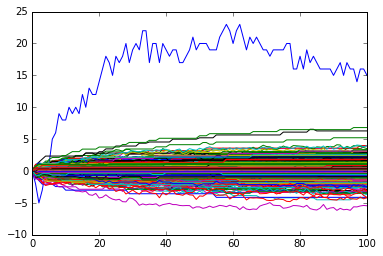

In [9]:
paramhist.plot(legend=None)